In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from nets.cut import Cut
from pytorch_lightning import Trainer
# from data_loader_gaelle import ConcatDataset,ImageDataset,LotusDataModule, ConcatDataModule, LotusTrainTransforms2
import pandas as pd
import numpy as np 

from callbacks import logger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.strategies.ddp import DDPStrategy

from monai.transforms import (  
    LoadImaged,
    Compose,
    Resize,
    RandZoomd,
    RandRotated,
    RandAffined,
    ToTensord
)   
import math

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import SimpleITK as sitk
from PIL import Image
# import nrrd
import os
import sys
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import monai
from monai.transforms import (  
    LoadImaged,
    Compose,
    Resize,
    RandZoomd,
    RandRotated,
    RandAffined,
    ToTensord,
    EnsureTyped,
    Spacingd,
    Resized,
    EnsureChannelFirstd
)   
import math

import pytorch_lightning as pl


<h1 style="font-size:24px; color:red; text-decoration:underline; font-weight:bold;">
  Reading CSV files for training
</h1>


In [4]:
df_train_cbct = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT_2D/a1_training_CBCT_2D/train.csv") 
df_val_cbct = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT_2D/a1_training_CBCT_2D/valid.csv")  
df_test_cbct = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT_2D/a1_training_CBCT_2D/test.csv")

df_train_mri = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT_2D/a1_training_MRI_2D/train.csv")
df_val_mri = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT_2D/a1_training_MRI_2D/valid.csv")   
df_test_mri = pd.read_csv("/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT_2D/a1_training_MRI_2D/test.csv") 


print(df_train_mri.columns)  # Affiche les noms de colonnes du DataFrame
print(df_train_mri.head())   # Affiche les premières lignes pour vérifier les données


print("df_train_cbct : ",df_train_cbct)

Index(['index', 'img_fn', 'group', 'ignore_size_info', 'label'], dtype='object')
   index                       img_fn group  ignore_size_info  label
0      0  train/M023_OR_slice_000.png     .                 0      1
1      1  train/M023_OR_slice_001.png     .                 0      2
2      2  train/M023_OR_slice_002.png     .                 0      3
3      3  train/M023_OR_slice_003.png     .                 0      4
4      4  train/M023_OR_slice_004.png     .                 0      5
df_train_cbct :         index                            img_fn group  ignore_size_info  label
0          0  train/B040_cropped_slice_000.png     .                 0      1
1          1  train/B040_cropped_slice_001.png     .                 0      2
2          2  train/B040_cropped_slice_002.png     .                 0      3
3          3  train/B040_cropped_slice_003.png     .                 0      4
4          4  train/B040_cropped_slice_004.png     .                 0      5
...      ...        

type(dataset) :  <class 'monai.data.dataset.Dataset'>


type(img_after) :  <class 'list'>
len(img_after) :  1
img_after.shape :  torch.Size([1, 256, 256])


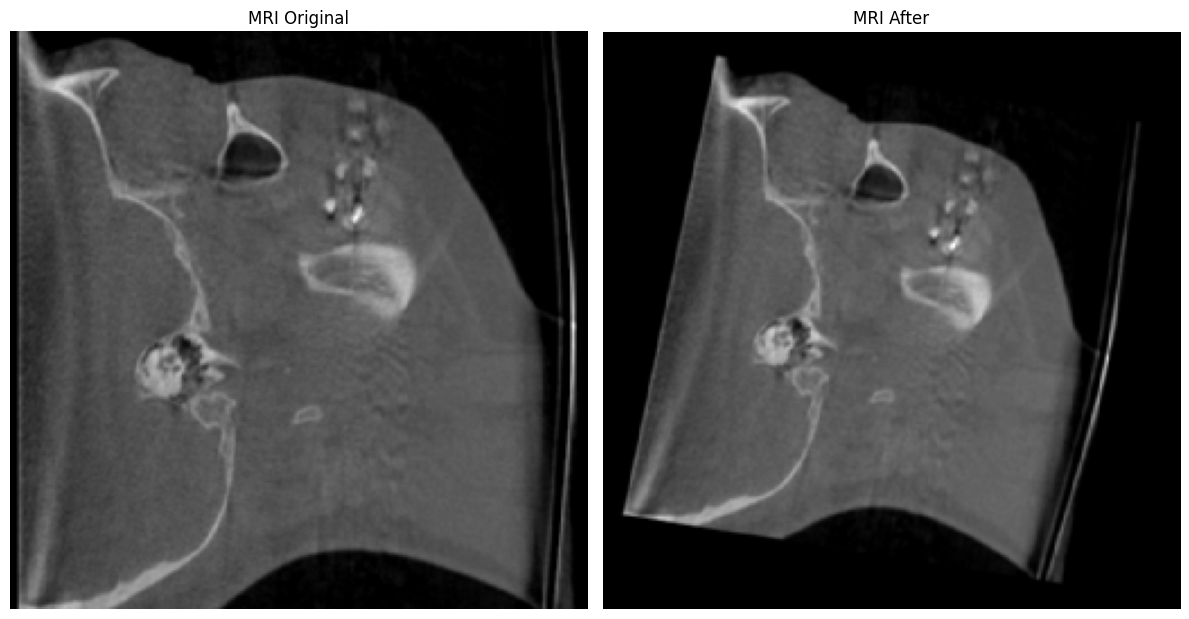

In [23]:
import matplotlib.pyplot as plt

from monai.transforms import NormalizeIntensityd,ScaleIntensityd

img_path = "/home/lucia/Documents/Gaelle/Data/MultimodelReg/MRI_to_CBCT_2D/a1_training_CBCT_2D/train/B040_cropped_slice_111.png"
df = [{"img": img_path}]
transform_test = Compose(
            [
        LoadImaged(keys=['img']),
        EnsureChannelFirstd(keys=['img']),

        EnsureTyped(keys=['img']),
        NormalizeIntensityd(keys=['img'] ),
        ScaleIntensityd(keys=['img']),
        RandZoomd(keys=['img'], min_zoom=0.8, max_zoom=1.2, mode=['area'], prob=0.8, padding_mode='constant'),

        RandRotated(keys=['img'], range_x=np.pi/4, mode=['bilinear'], prob=1.0),

        RandAffined(keys=['img'], prob=0.8, shear_range=(0.1, 0.3), mode=['bilinear'], padding_mode='zeros'),

        Resized(keys=['img'], spatial_size=(256, 256)),  # Redimensionne les images

        ToTensord(keys=['img']),
        ]
        )

transform_just_tensor = Compose(
            [
        LoadImaged(keys=['img']),
        EnsureChannelFirstd(keys=['img']),

        EnsureTyped(keys=['img']),

        Resized(keys=['img'], spatial_size=(256,256)),  # Redimensionne les images

        ToTensord(keys=['img']),
        ]
        )
# Création d'un dataset pour appliquer les transformations
# dataset = Dataset([df], transform=transform_test)
dataset = monai.data.Dataset(data=df, transform=transform_test)
dataset_just_tensor = monai.data.Dataset(data=df, transform=transform_just_tensor)

print("type(dataset) : ",type(dataset))
# print("dataset : ",dataset)
# Exécutez les transformations et récupérez les images en tenseurs
img_after = [data["img"] for data in dataset]
img_ori = [data["img"] for data in dataset_just_tensor]
print("type(img_after) : ",type(img_after))
print("len(img_after) : ",len(img_after))
print("img_after.shape : ",img_after[0].shape)

fig, axs = plt.subplots(1, 2, figsize=(12, 12))

# Top-left image
axs[0].imshow(img_ori[0][0], cmap="gray")
axs[0].set_title("MRI Original")
axs[0].axis("off")

# Top-right image
axs[1].imshow(img_after[0][0], cmap="gray")
axs[1].set_title("MRI After")
axs[1].axis("off")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()




<h1 style="font-size:24px; color:red; text-decoration:underline; font-weight:bold;">
  TEST Generator,Head,Discriminator
</h1>

In [1]:
from nets.cut_G import Generator
from nets.cut_P import Head
from nets.cut_D import Discriminator
import torch

In [2]:
G = Generator()
D_Y = Discriminator()
H = Head()
# H = Head_original()

In [4]:
G(torch.rand(1, 1, 256, 256))
D_Y(torch.rand(1, 1, 256, 256))
tgt = torch.rand(1, 1, 256, 256)
src = torch.rand(1, 1, 256,256)
feat_q, patch_ids_q = G(tgt, encode_only=True)
feat_k, _ = G(src, encode_only=True, patch_ids=patch_ids_q)

feat_k_pool =H(feat_k)
feat_q_pool = H(feat_q)
